In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms, datasets
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time

from ae_mnist import ConvAutoencoder_GELU, ConvAutoencoder_ReLU
from utils import fgsm_attack, pgd_linf, to_numpy_array, EarlyStopping
from lenet import Net

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = 'mnist'
attack_type = 'pgd'
activation_type = 'gelu'
lr = 0.001
batch_size = 16
num_epochs = 30
z_dim = 10
include_noise = True

# FGSM parameters
eps_fgsm = 0.3
#PGD parameters
eps_pgd, alpha, num_iter = 0.15, 1e-2, 40

In [3]:
# MNIST Dataset
transform=transforms.Compose([
            transforms.ToTensor(),
])

dataset = datasets.MNIST(root= './data', train = True, download =True, transform = transform)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000])

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [5]:
classifier = Net()
classifier.to(device)
classifier.load_state_dict(torch.load('./lenet_mnist_model.pth'))

FileNotFoundError: [Errno 2] No such file or directory: './lenet_mnist_model.pth'

In [9]:
if activation_type == 'gelu':
    convAE = ConvAutoencoder_GELU(device, z_dim, include_noise)
else:
    convAE = ConvAutoencoder_ReLU(device, z_dim, include_noise)
convAE.to(device)
# Loss function
criterion = nn.MSELoss()
# Optimizer
optimizer = optim.Adam(convAE.parameters(), lr=lr)
# Early stopping criteria
early_stopping = EarlyStopping()
# Check the model
convAE

ConvAutoencoder_GELU(
  (encoder_conv2D): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): GELU(approximate='none')
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_linear): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder_linear): Sequential(
    (0): Linear(in_features=10, out_features=128, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): GELU(approximate='none')
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_convt2d

In [10]:
from torchsummary import summary

summary(convAE, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 14, 14]              80
              GELU-2            [-1, 8, 14, 14]               0
            Conv2d-3             [-1, 16, 7, 7]           1,168
       BatchNorm2d-4             [-1, 16, 7, 7]              32
              GELU-5             [-1, 16, 7, 7]               0
            Conv2d-6             [-1, 32, 3, 3]           4,640
              GELU-7             [-1, 32, 3, 3]               0
           Flatten-8                  [-1, 288]               0
            Linear-9                  [-1, 128]          36,992
             GELU-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
           Linear-12                  [-1, 128]           1,408
             GELU-13                  [-1, 128]               0
           Linear-14                  [

In [38]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [39]:
def load_checkpoint(checkpoint):
    convAE.load_state_dict(checkpoint['convAE_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    return checkpoint['train_losses'], checkpoint['val_losses']

def save_checkpoint(checkpoint, model_path):
    torch.save(checkpoint, model_path)

In [40]:
load_model = False
if include_noise:
    file_path = f'./ae_mnist_{attack_type}_{activation_type}_proposed.pth.tar'
else:
    file_path = f'./ae_mnist_{attack_type}_{activation_type}_vanilla.pth.tar'

train_losses, val_losses = [], []

if load_model:
    train_losses, val_losses = load_checkpoint(torch.load(file_path))

len(train_losses), len(val_losses)

(0, 0)

In [ ]:
start_time = time.time()

for epoch in range(num_epochs):
    train_loss, val_loss = 0.0, 0.0

    for _, (imgs, labels) in enumerate(train_loader):
        # print(imgs.shape)
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
        
        if attack_type == 'fgsm':
            adv_imgs, _ = fgsm_attack(classifier, imgs, labels, eps_fgsm)
        else:
            adv_imgs, _ = pgd_linf(classifier, imgs, labels, eps_pgd, alpha, num_iter, dataset)
            
        adv_imgs = adv_imgs.to(device)

        optimizer.zero_grad()
        rec_imgs = convAE.forward(adv_imgs)
        loss = criterion(imgs, rec_imgs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*batch_size

    for _, (imgs, labels) in enumerate(val_loader):
        # print(imgs.shape)
        batch_size = imgs.shape[0]
        imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))

        if attack_type == 'fgsm':
            adv_imgs, _ = fgsm_attack(classifier, imgs, labels, eps_fgsm, dataset)
        else:
            adv_imgs, _ = pgd_linf(classifier, imgs, labels, eps_pgd, alpha, num_iter)

        adv_imgs = adv_imgs.to(device)

        optimizer.zero_grad()
        rec_imgs = convAE.forward(adv_imgs)
        loss = criterion(imgs, rec_imgs)
        loss.backward()
        optimizer.step()
        val_loss += loss.item()*batch_size
    
    train_loss, val_loss = train_loss/len(train_dataset), val_loss/len(val_dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}/{num_epochs}, train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, \
          time_taken: {(time.time()-start_time)/60:.2f} mins')
    
    checkpoint = {
        'convAE_state_dict': convAE.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses, 'val_losses': val_losses
    }

    save_checkpoint(checkpoint, file_path)

    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
        print("Early Stopping critieria satisfied")
        break
        

Epoch: 1/30, train_loss: 0.0352, val_loss: 0.0200,           time_taken: 6.12 mins
Epoch: 2/30, train_loss: 0.0180, val_loss: 0.0167,           time_taken: 12.28 mins
Epoch: 3/30, train_loss: 0.0160, val_loss: 0.0156,           time_taken: 18.39 mins
Epoch: 4/30, train_loss: 0.0152, val_loss: 0.0149,           time_taken: 24.49 mins
Epoch: 5/30, train_loss: 0.0146, val_loss: 0.0144,           time_taken: 30.58 mins
Epoch: 6/30, train_loss: 0.0142, val_loss: 0.0140,           time_taken: 36.69 mins
Epoch: 7/30, train_loss: 0.0138, val_loss: 0.0138,           time_taken: 42.80 mins
Epoch: 8/30, train_loss: 0.0136, val_loss: 0.0135,           time_taken: 48.92 mins
Epoch: 9/30, train_loss: 0.0134, val_loss: 0.0133,           time_taken: 55.02 mins
Epoch: 10/30, train_loss: 0.0132, val_loss: 0.0132,           time_taken: 61.13 mins
Epoch: 11/30, train_loss: 0.0131, val_loss: 0.0130,           time_taken: 67.22 mins
Epoch: 12/30, train_loss: 0.0129, val_loss: 0.0129,           time_taken: 7

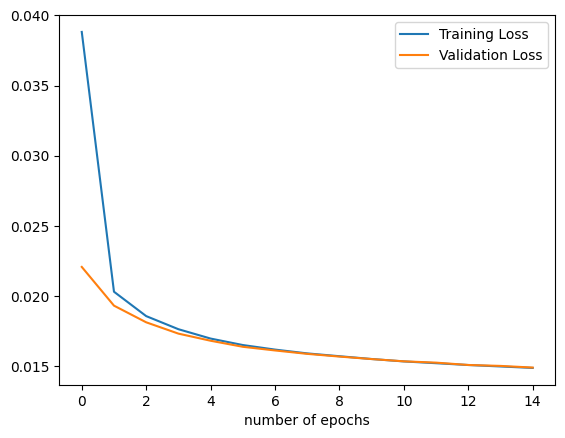

In [26]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('number of epochs')
plt.legend()
plt.show()

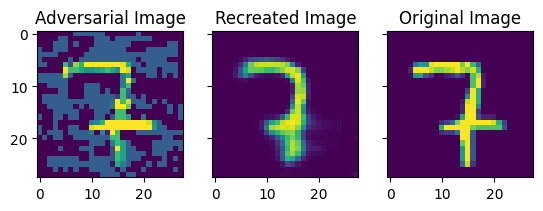

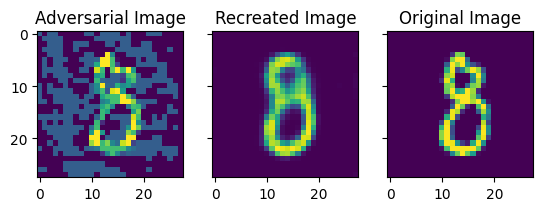

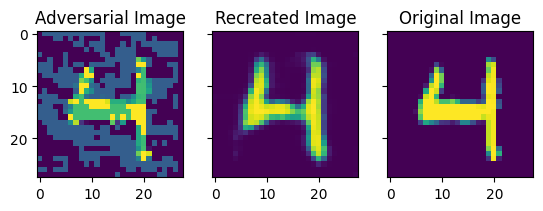

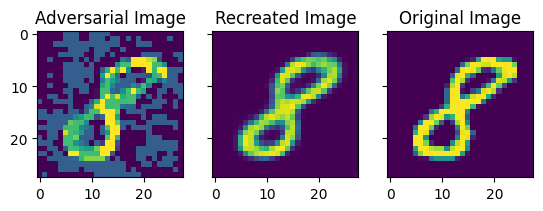

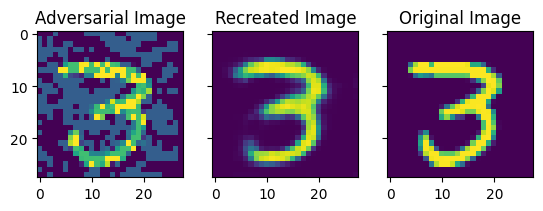

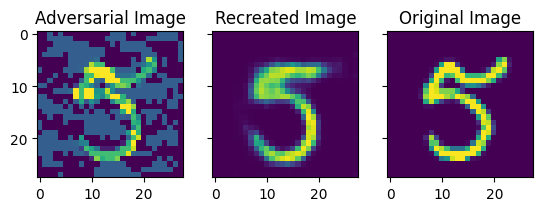

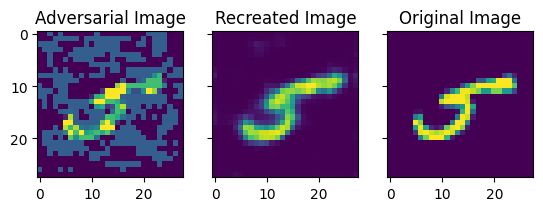

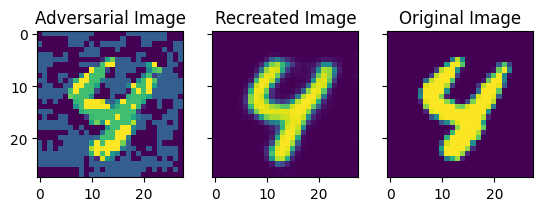

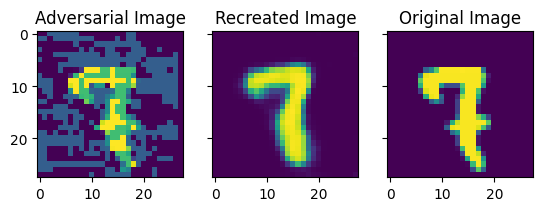

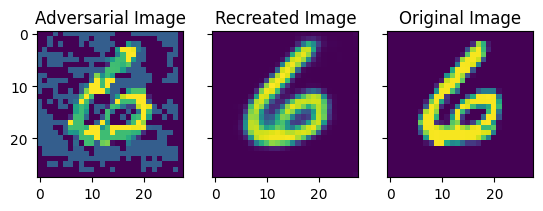

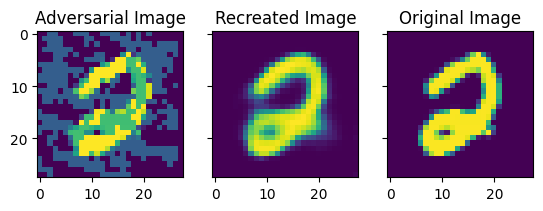

In [27]:
for i, (imgs, labels) in enumerate(val_loader):
    batch_size = imgs.shape[0]
    imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
    
    if attack_type == 'fgsm':
        adv_imgs, _ = fgsm_attack(classifier, imgs, labels, eps_fgsm, dataset)
    else:
        adv_imgs, _ = pgd_linf(classifier, imgs, labels, eps_pgd, alpha, num_iter)

    adv_imgs = adv_imgs.to(device)

    with torch.no_grad():
        rec_imgs = convAE(adv_imgs)

    imgs, adv_imgs, rec_imgs = to_numpy_array(imgs[0]), to_numpy_array(adv_imgs[0]), to_numpy_array(rec_imgs[0])

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    ax1.imshow(adv_imgs)
    ax1.set_title("Adversarial Image")
    ax2.imshow(rec_imgs)
    ax2.set_title("Recreated Image")
    ax3.imshow(imgs)
    ax3.set_title("Original Image")
    # f.plot()

    if (i == 10):
        break

In [28]:
test_dataset = datasets.MNIST(root= './data', train = False, download =True, transform = transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [29]:
correct, total = 0, 0

for _, (imgs, labels) in enumerate(test_loader):
    batch_size = imgs.shape[0]
    imgs, labels = Variable(imgs.to(device), requires_grad=True), Variable(labels.to(device))
    
    if attack_type == 'fgsm':
        adv_imgs, _ = fgsm_attack(classifier, imgs, labels, eps_fgsm, dataset)
    else:
        adv_imgs, _ = pgd_linf(classifier, imgs, labels, eps_pgd, alpha, num_iter)

    adv_imgs = adv_imgs.to(device)

    with torch.no_grad():
        rec_imgs = convAE(adv_imgs)

    y_preds = classifier(rec_imgs).argmax(dim=1)
    correct += (y_preds==labels).sum().item()
    total += labels.size(0)

In [30]:
print("Epsilon: {}, Test Accuracy: {}".format(eps_fgsm, correct / total))

Epsilon: 0.3, Test Accuracy: 0.9087
